# 1. Manual modeling (SARIMAX)

## 2. Imports

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
import warnings
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import yfinance as yf

## 3. Creating the model

[*********************100%***********************]  1 of 1 completed


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=413.526, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=315.735, Time=0.29 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=411.584, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=337.710, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=315.200, Time=0.81 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.37 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=315.957, Time=0.95 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=315.499, Time=0.88 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=350.157, Time=0.77 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=315.672, Time=1.00 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=313.212, T

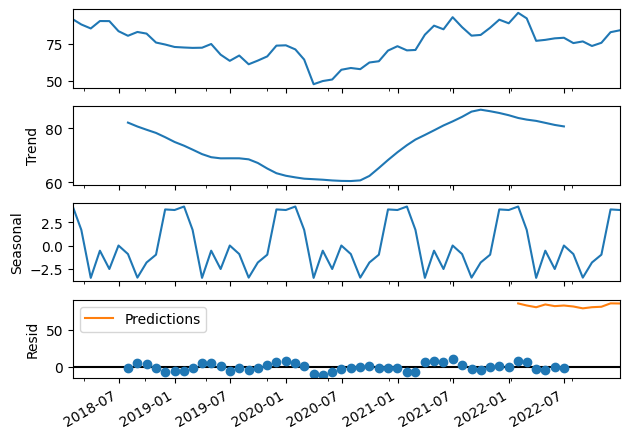

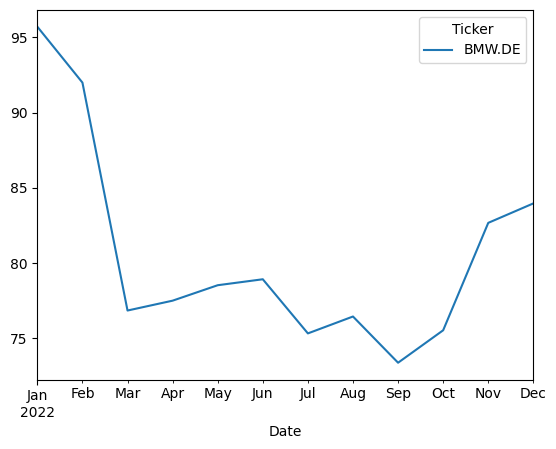

In [2]:
# Disable warnings
warnings.filterwarnings("ignore")

# Load data from yfinance
data = yf.download('BMW.DE', start='2018-01-01', end='2023-01-01')
data = data[["Close"]].dropna()  # Keep only the 'Close' column and remove missing values

data.to_csv("Datasets/bmw_stock_data_2018_2023.csv")

# Resample data to monthly frequency (sum is not appropriate for stock prices, so we use mean)
data_monthly = data.resample('M').mean()

# Decompose the time series data
result = seasonal_decompose(data_monthly['Close'], model='additive')
result.plot()

# Auto ARIMA for model selection
stepwise_fit = auto_arima(data_monthly['Close'], 
                          start_p=1, start_q=1, 
                          max_p=3, max_q=3, 
                          m=12, start_P=0, 
                          seasonal=True, 
                          d=None, D=1, trace=True, 
                          error_action='ignore', 
                          suppress_warnings=True, 
                          stepwise=True)

# Print summary of the best model
print(stepwise_fit.summary())

# Split data into train and test sets (one year for testing)
train = data_monthly.iloc[:len(data_monthly)-12]
test = data_monthly.iloc[len(data_monthly)-12:]

# Fit the SARIMAX model using the best parameters from Auto ARIMA
model = SARIMAX(train['Close'], 
                order=(1, 0, 0), 
                seasonal_order=(0, 1, 1, 12))

result = model.fit()
print(result.summary())

# Write the model of BMW away in a pickle file
with open('Models/bmw_stockprice_model.pkl', 'wb') as pkl_file:
    pickle.dump(result, pkl_file)

# Make predictions for the test set
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start, end, typ='levels').rename("Predictions")

# Plot predictions and actual values
predictions.plot(legend=True)
test['Close'].plot(legend=True)

# Evaluate the model
print("Root Mean Squared Error:", rmse(test["Close"], predictions))
print("Mean Squared Error:", mean_squared_error(test["Close"], predictions))

# Load the model from the pickle file
with open('Models/bmw_stockprice_model.pkl', 'rb') as pkl_file:
    bmw_model = pickle.load(pkl_file)

## 3. Predicting the near future (Stockprice)

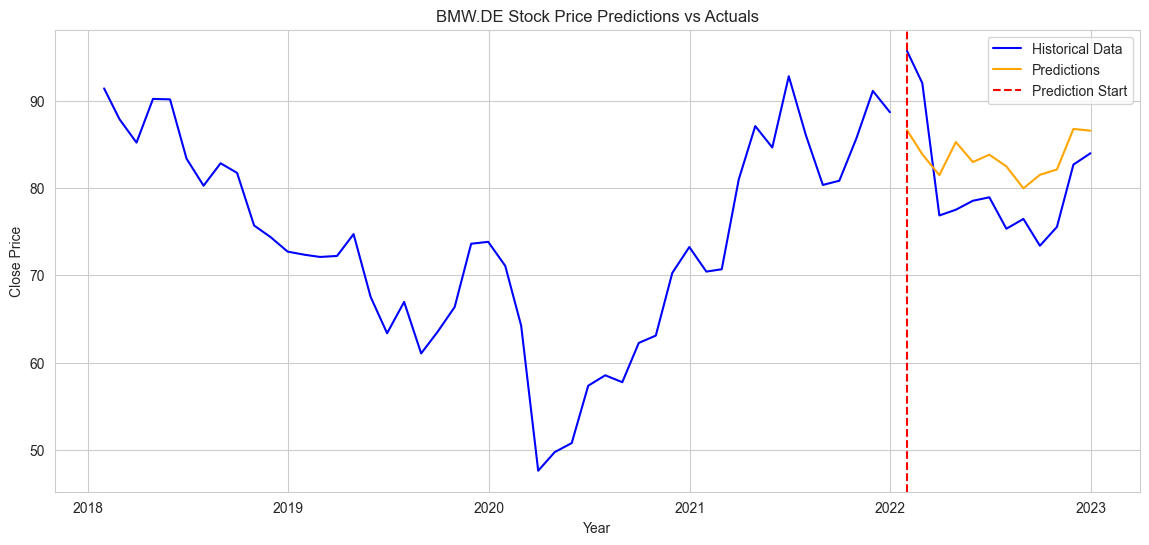

In [3]:
# Make predictions for the test set
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start=start, end=end, typ='levels').rename("Predictions")

# Ensure predictions and test data have matching indices
predictions.index = test.index

# Plot predictions and actual values
sns.set_style('whitegrid')

plt.figure(figsize=(14, 6))
plt.plot(train.index, train['Close'], label='Historical Data', color='blue')
plt.plot(test.index, test['Close'], color='blue')
plt.plot(predictions.index, predictions, label='Predictions', color='orange')
plt.axvline(x=test.index[0], color='red', linestyle='--', label='Prediction Start')
plt.legend(loc='best')
plt.title("BMW.DE Stock Price Predictions vs Actuals")
plt.ylabel("Close Price")
plt.xlabel("Year")
plt.show()

## 4. Load the model and fetch fresh data of the past 5 years

In [4]:
with open('Models/bmw_stockprice_arima_model.pkl', 'rb') as pkl_file:
    bmw_model = pickle.load(pkl_file)

    # Fetch Mercedes stock data
data_mercedes = yf.download('MBG.DE', start='2018-01-01', end='2023-01-01')
data_mercedes = data_mercedes[["Close"]].dropna()

# Resample data to monthly frequency
data_mercedes_monthly = data_mercedes.resample('M').mean()

# Split data into train and test sets (last 12 months for testing)
train_mercedes = data_mercedes_monthly.iloc[:-12]
test_mercedes = data_mercedes_monthly.iloc[-12:]

# Use the BMW model to predict Mercedes prices
start = len(train_mercedes)
end = len(train_mercedes) + len(test_mercedes) - 1

[*********************100%***********************]  1 of 1 completed


## 5. Trying the ARIMA model (BMW) to predict the Mercedes stockprice

In [5]:
# Generate predictions
predictions_mercedes = bmw_model.predict(start=start, end=end, typ='levels').rename("Predictions")

# Align predictions with test index
predictions_mercedes.index = test_mercedes.index

## 6. Visualize the ARIMA model (BMW) to predict the Mercedes stockprice

As you can see the Arima model of BMW predicts a very different close price then the actual mercedes close price. Although the prediction isn't that bad we recommend creating a seperate model for predicting the mercedes stock prices. The reason behind this is dat mercedes has a lower closing price then BMW. That's why model is predicting a higher closing time in the near future.

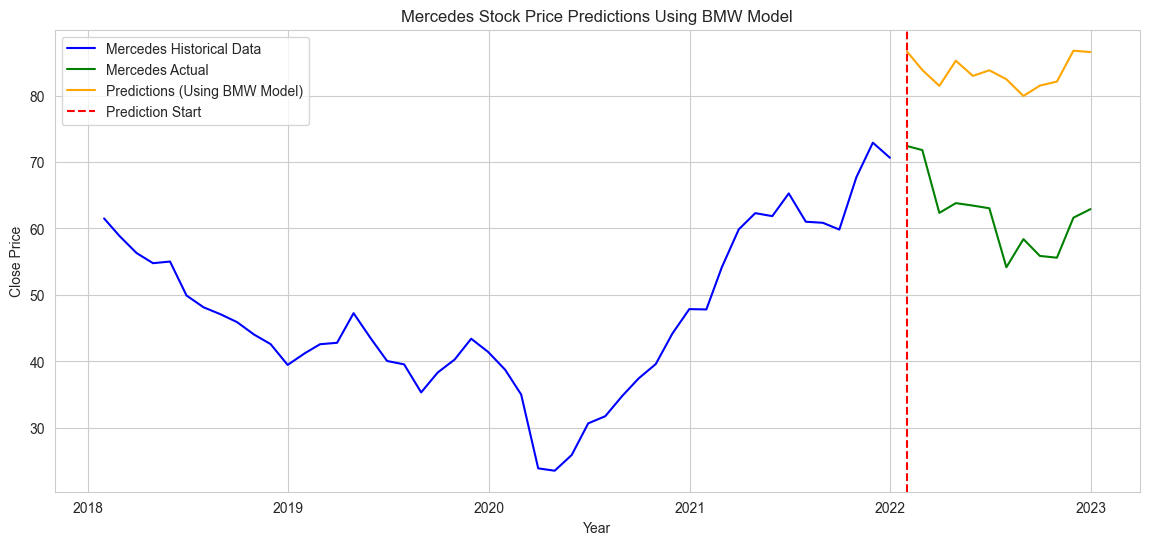

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot predictions and actual values
sns.set_style('whitegrid')

plt.figure(figsize=(14, 6))
plt.plot(train_mercedes.index, train_mercedes['Close'], label='Mercedes Historical Data', color='blue')
plt.plot(test_mercedes.index, test_mercedes['Close'], color='green', label='Mercedes Actual')
plt.plot(predictions_mercedes.index, predictions_mercedes, label='Predictions (Using BMW Model)', color='orange')
plt.axvline(x=test_mercedes.index[0], color='red', linestyle='--', label='Prediction Start')
plt.legend(loc='best')
plt.title("Mercedes Stock Price Predictions Using BMW Model")
plt.ylabel("Close Price")
plt.xlabel("Year")
plt.show()


# 7. PyCaret Modeling

In [7]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from pycaret import *

## 8. Data Collection

Like previous we use we use the yfinance library to download BMW stock data from 2018 to 2023. This data provides the historical closing prices, which will be the foundation for our forecasting pycaret model.

In [8]:
# Download BMW stock data from Yahoo Finance
bmw_data = yf.download("BMW.DE", start="2018-01-01", end="2022-01-01")
bmw_data = bmw_data.dropna()

bmw_data= bmw_data[['Close']]
bmw_data.reset_index(level=0, inplace=True)
bmw_data['Date'] = pd.to_datetime(bmw_data['Date'])
bmw_data

[*********************100%***********************]  1 of 1 completed


Price,Date,Close
Ticker,,BMW.DE
0,2018-01-02,86.400002
1,2018-01-03,86.860001
2,2018-01-04,87.480003
3,2018-01-05,88.500000
4,2018-01-08,89.669998
...,...,...
1007,2021-12-23,89.169998
1008,2021-12-27,90.000000
1009,2021-12-28,89.949997


## 9.  Preparing the BMW Stock Data

To ready our BMW stock data for time series analysis, we begin by converting the Date column into a consistent datetime format. This ensures smooth handling of time-based data.
Next, we group the data by date to eliminate duplicates and set a daily frequency, creating a seamless timeline. Any missing values, often due to non-trading days, are filled forward to maintain continuity.

This clean and complete dataset is now perfectly structured for forecasting and analysis

In [9]:
bmw_data['Date']=bmw_data['Date'].astype(str)
bmw_data['Date'] = pd.to_datetime(bmw_data['Date'])
bmw_data = bmw_data.groupby('Date').sum()
bmw_data = bmw_data.asfreq(freq ='D')
bmw_data['Close'] = bmw_data['Close'].ffill()
bmw_data

Price,Close
Ticker,BMW.DE
Date,
2018-01-02,86.400002
2018-01-03,86.860001
2018-01-04,87.480003
2018-01-05,88.500000
2018-01-06,88.500000
...,...
2021-12-26,89.169998
2021-12-27,90.000000


## 10. Setting Up PyCaret for Time Series Forecasting

With our data cleaned and prepared, the next step is to leverage PyCaret's powerful time series forecasting capabilities.

- fh=7: Setting a forecasting horizon of 7 days to predict the upcoming week.
- fold=3: Performing 3-fold cross-validation to ensure robust model evaluation.
- session_id=123: Setting a random seed for reproducibility, so results remain consistent across runs.

In [10]:
from pycaret.time_series import *
setup(bmw_data, fh = 7, fold = 3, session_id = 123)

,Description,Value
0,session_id,123
1,Target,"('Close', 'BMW.DE')"
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1459, 1)"
5,Transformed data shape,"(1459, 1)"
6,Transformed train set shape,"(1452, 1)"
7,Transformed test set shape,"(7, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


## 11. Identifying the Best Forecasting Model (Elastic Net)

Once the setup is complete, the next step is to find the most accurate forecasting model.

Using the compare_models() function, PyCaret evaluates a wide range of time series models against our BMW stock price data. By sorting the results based on Mean Absolute Error (MAE), we ensure the selection prioritizes models that minimize prediction errors.

Here, we specify n_select=1, instructing PyCaret to identify and return only the single best-performing model. This model will serve as the foundation for our 7-day forecasts.

In [11]:
best = compare_models(sort = 'MAE', n_select=1)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.5905,0.5465,1.2573,1.5372,0.0143,0.0142,-1.3412,0.3967
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.6173,0.5832,1.3145,1.6409,0.0148,0.0149,-1.6224,0.8067
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.6178,0.5596,1.3154,1.5743,0.0149,0.0149,-1.4022,0.2367
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.6178,0.5596,1.3154,1.5743,0.0149,0.0149,-1.4022,0.2200
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.6401,0.5909,1.3628,1.6620,0.0155,0.0154,-2.0533,0.2067
croston,Croston,0.6531,0.5353,1.3906,1.5056,0.0159,0.0157,-1.3758,0.0333
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.6532,0.5981,1.3907,1.6821,0.0159,0.0157,-2.1053,0.2200
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.6538,0.5985,1.3920,1.6835,0.0159,0.0157,-2.1111,0.5700
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.6539,0.5986,1.3922,1.6837,0.0159,0.0157,-2.1121,0.4700
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.6623,0.6028,1.4101,1.6956,0.0161,0.0159,-2.2529,0.2300


In [12]:
import pickle

with open('Models/best_bmw_model_pycaret.pkl', 'wb') as file: 
    pickle.dump(best, file)

## 12. Forecasting 

This forecast serves as a valuable tool for investors and analysts to make informed decisions. However, it's crucial to remember that the stock market is inherently unpredictable. By continuously monitoring market dynamics and refining our models, we can strive to improve the accuracy of future forecasts.

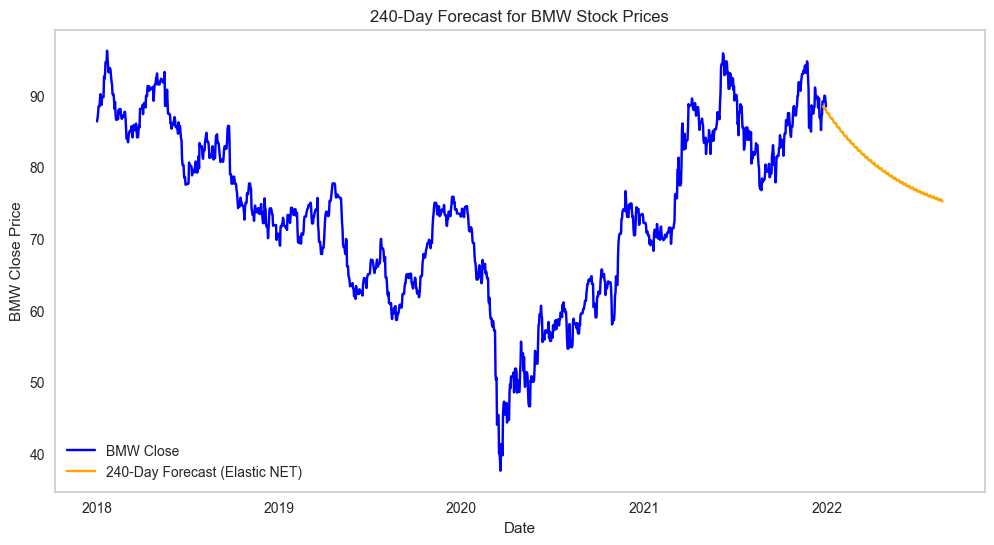

In [13]:
# Load your existing best model
with open('Models/best_bmw_model_pycaret.pkl', 'rb') as file: 
    best_model = pickle.load(file)

# Forecast for the next 90 days
forecast = predict_model(best_model, fh=240)

# Create a plot for the forecast
plt.figure(figsize=(12, 6))
plt.plot(bmw_data.index, bmw_data['Close'], label="BMW Close", color="blue")
plt.plot(forecast.index, forecast['y_pred'], label="240-Day Forecast (Elastic NET)", color="orange")
plt.xlabel("Date")
plt.ylabel("BMW Close Price")
plt.title("240-Day Forecast for BMW Stock Prices")
plt.legend()
plt.grid()
plt.show()

# Conclusion

This analysis highlights stock price patterns, the impact of major events like COVID-19, and the power of predictive modeling for financial insights.

By leveraging PyCaret's Elastic Net model, we have successfully predicted BMW's stock prices. This journey highlights the power of machine learning in financial analysis, providing us with tools to make informed decisions based on data-driven insights.

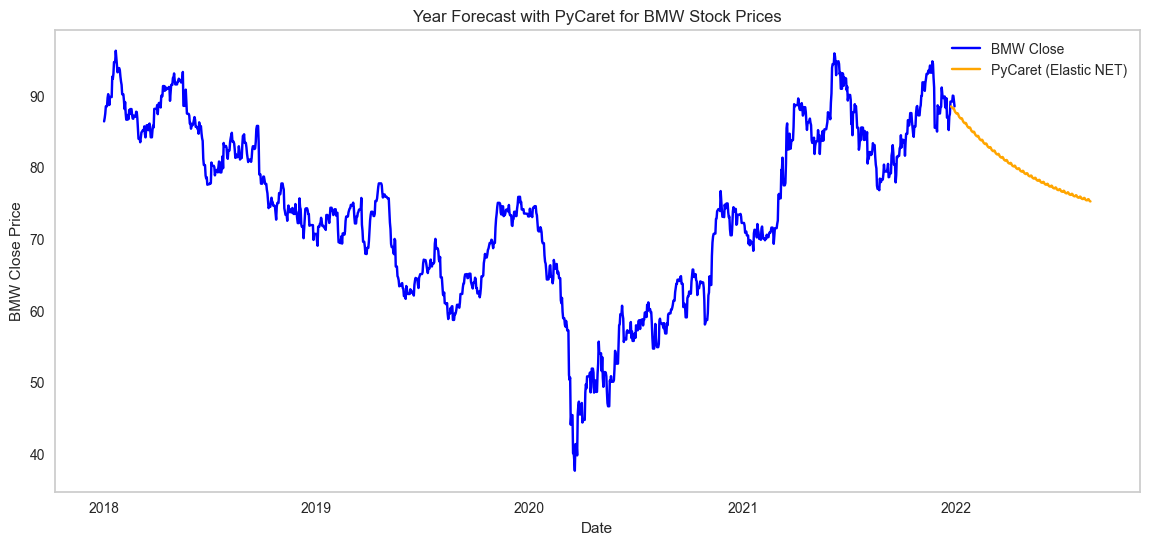

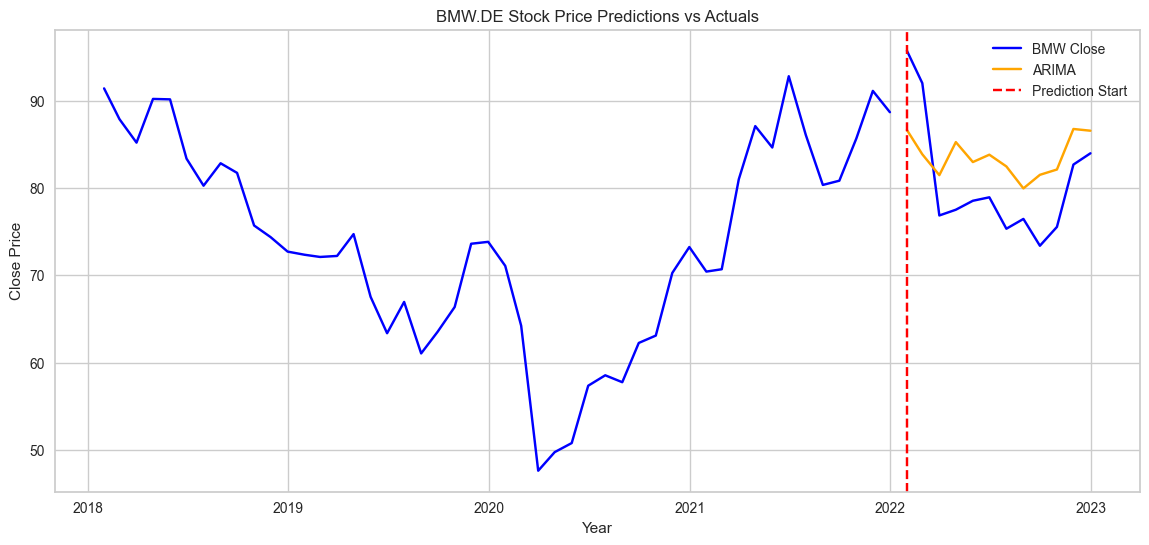

In [ ]:
# Load your existing best model
with open('Models/best_bmw_model_pycaret.pkl', 'rb') as file: 
    best_model = pickle.load(file)

# Forecast for the next 90 days
forecast = predict_model(best_model, fh=240)

# Create a plot for the forecast
plt.figure(figsize=(14, 6))
plt.plot(bmw_data.index, bmw_data['Close'], label="BMW Close", color="blue")
plt.plot(forecast.index, forecast['y_pred'], label="PyCaret (Elastic NET)", color="orange")
plt.xlabel("Date")
plt.ylabel("BMW Close Price")
plt.title("Year Forecast with PyCaret for BMW Stock Prices")
plt.legend()
plt.grid()
plt.show()

# Make predictions for the test set
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start=start, end=end, typ='levels').rename("Predictions")

# Ensure predictions and test data have matching indices
predictions.index = test.index

# Plot predictions and actual values
sns.set_style('whitegrid')

plt.figure(figsize=(14, 6))
plt.plot(train.index, train['Close'], label='BMW Close', color='blue')
plt.plot(test.index, test['Close'], color='blue')
plt.plot(predictions.index, predictions, label='ARIMA', color='orange')
plt.axvline(x=test.index[0], color='red', linestyle='--', label='Prediction Start')
plt.legend(loc='best')
plt.title("BMW.DE Stock Price Predictions vs Actuals")
plt.ylabel("Close Price")
plt.xlabel("Year")
plt.show()